In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchinfo import summary
from torch import GradScaler, autocast

import statsmodels.api as sm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error, r2_score

import random
import os
import albumentations
from tqdm import tqdm
from datetime import datetime
import pytz
import copy
import gc
import zipfile
from IPython.display import FileLink

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

print("imports done")

imports done


In [12]:
os.listdir("../input/sta457-project-data/")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../input/sta457-project-data/'

In [69]:
path = "../data/"

In [70]:
ghana_df = pd.read_csv(path+"Ghana_data.csv")
ghana_df["Date"] = pd.to_datetime(ghana_df["DATE"], format="%Y-%m-%d")
ghana_df = ghana_df.set_index("Date")
ghana_df

,STATION,NAME,DATE,PRCP,TAVG,TMAX,TMIN
Date,,,,,,,
1990-01-01,GHM00065472,"KOTOKA INTERNATIONAL, GH",1990-01-01,NaN,80,91.0,76.0
1990-01-02,GHM00065472,"KOTOKA INTERNATIONAL, GH",1990-01-02,NaN,81,92.0,NaN
1990-01-03,GHM00065472,"KOTOKA INTERNATIONAL, GH",1990-01-03,NaN,82,NaN,NaN
1990-01-04,GHM00065472,"KOTOKA INTERNATIONAL, GH",1990-01-04,NaN,81,NaN,75.0
1990-01-05,GHM00065472,"KOTOKA INTERNATIONAL, GH",1990-01-05,0.0,79,89.0,75.0
...,...,...,...,...,...,...,...
2024-11-24,GHM00065439,"SUNYANI, GH",2024-11-24,NaN,83,94.0,71.0
2024-11-25,GHM00065439,"SUNYANI, GH",2024-11-25,NaN,82,93.0,71.0
2024-11-26,GHM00065439,"SUNYANI, GH",2024-11-26,NaN,83,90.0,NaN


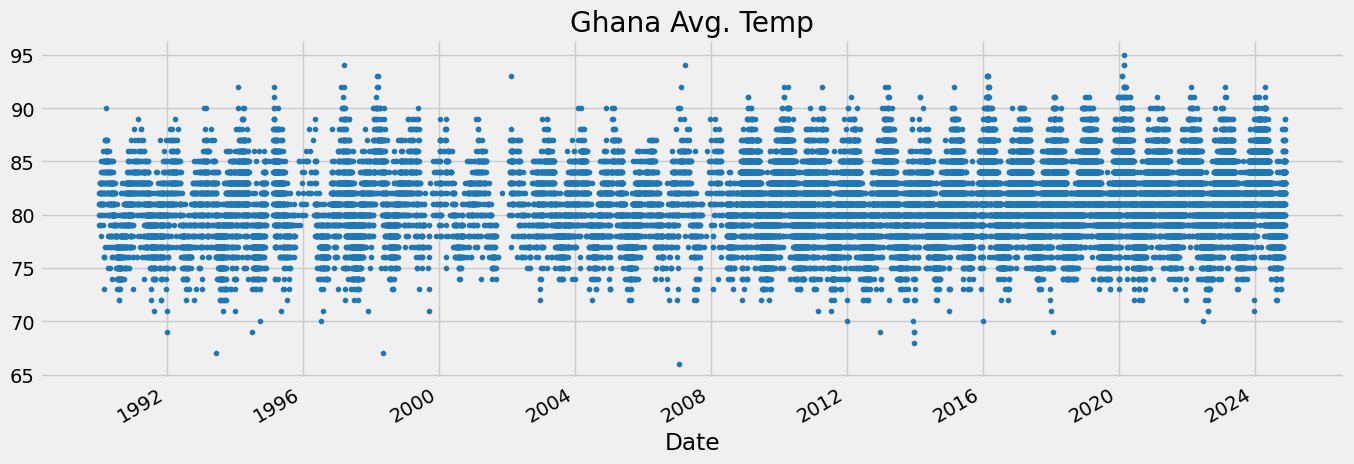

In [71]:
ghana_df["TAVG"].plot(style='.',
                      figsize=(15, 5),
                      color=color_pal[0],
                      title='Ghana Avg. Temp')
plt.savefig("ghana t_avg.png")
plt.show()

In [72]:
icco_df = pd.read_csv(path+"Daily Prices_ICCO.csv")
icco_df = icco_df.iloc[::-1].reset_index(drop=True)
icco_df["Date"] = pd.to_datetime(icco_df["Date"], format="%d/%m/%Y")
icco_df = icco_df.set_index("Date")
icco_df["ICCO daily price (US$/tonne)"] = icco_df["ICCO daily price (US$/tonne)"].str.replace(",", "").astype("float")
icco_df["icco_daily_price"] = icco_df["ICCO daily price (US$/tonne)"]
icco_df = icco_df.drop(["ICCO daily price (US$/tonne)"], axis=1)
icco_df

,icco_daily_price
Date,
1994-10-03,1466.24
1994-10-04,1462.28
1994-10-05,1430.57
1994-10-06,1430.32
1994-10-07,1416.46
...,...
2025-02-21,9106.42
2025-02-24,8408.72
2025-02-25,8668.57


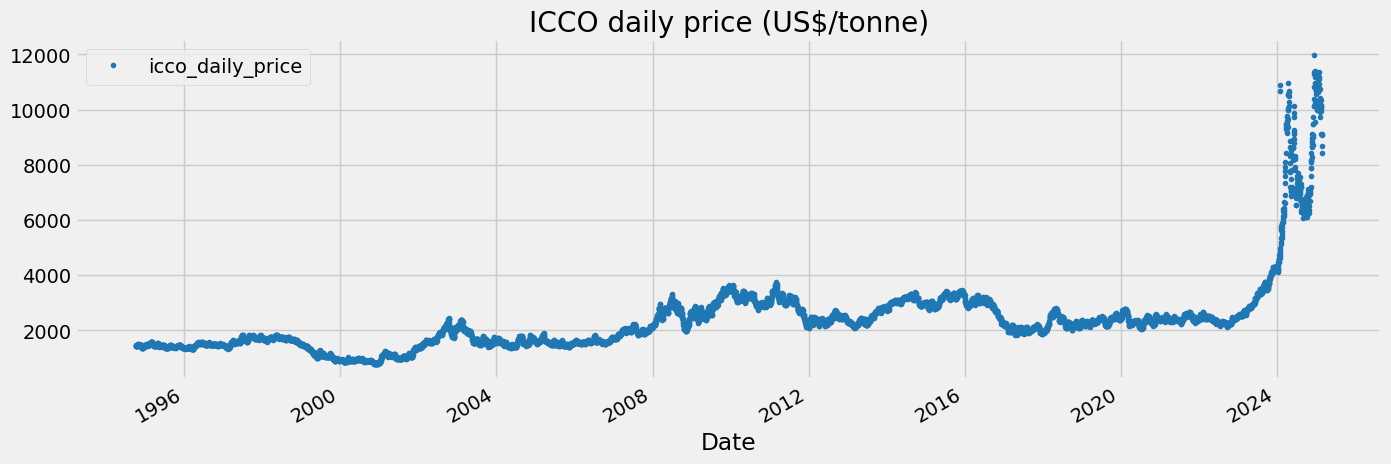

In [73]:
icco_df.plot(style='.',
             figsize=(15, 5),
             color=color_pal[0],
             title='ICCO daily price (US$/tonne)')
plt.savefig("icco prices.png")
plt.show()

In [74]:
xof_df = pd.read_csv(path+'USD_XOF Historical Data.csv')
xof_df = xof_df.iloc[::-1].reset_index(drop=True)
xof_df["Date"] = pd.to_datetime(xof_df["Date"], format="%Y-%m-%d")
xof_df = xof_df.set_index("Date")
xof_df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
1999-02-01,580.415,579.840,580.415,579.840,NaN,0.61%
1999-02-02,580.415,579.840,580.415,579.840,NaN,0.00%
1999-02-03,577.940,573.940,577.940,573.940,NaN,-0.43%
1999-02-04,577.940,573.940,577.940,573.940,NaN,0.00%
1999-02-05,577.940,573.940,577.940,573.940,NaN,0.00%
...,...,...,...,...,...,...
2018-04-23,556.600,552.720,556.600,549.460,NaN,0.35%
2018-04-24,555.725,557.475,558.955,554.275,NaN,-0.16%
2018-04-25,557.095,554.355,558.035,552.825,NaN,0.25%


In [75]:
xof_df.isna().sum()

Price          0
Open           0
High           0
Low            0
Vol.        4999
Change %       0
dtype: int64

In [76]:
xof_df = xof_df.drop(["Vol."], axis=1)
xof_df

,Price,Open,High,Low,Change %
Date,,,,,
1999-02-01,580.415,579.840,580.415,579.840,0.61%
1999-02-02,580.415,579.840,580.415,579.840,0.00%
1999-02-03,577.940,573.940,577.940,573.940,-0.43%
1999-02-04,577.940,573.940,577.940,573.940,0.00%
1999-02-05,577.940,573.940,577.940,573.940,0.00%
...,...,...,...,...,...
2018-04-23,556.600,552.720,556.600,549.460,0.35%
2018-04-24,555.725,557.475,558.955,554.275,-0.16%
2018-04-25,557.095,554.355,558.035,552.825,0.25%


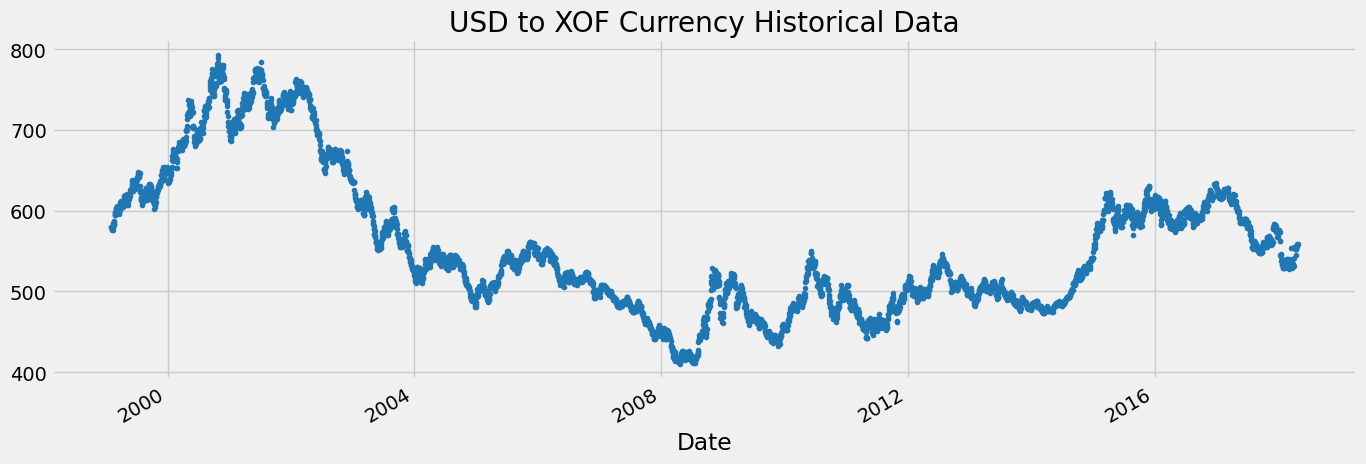

In [77]:
xof_df["Price"].plot(style='.',
                     figsize=(15, 5),
                     color=color_pal[0],
                     title='USD to XOF Currency Historical Data')
plt.savefig("usd_xof.png")
plt.show()

In [80]:
ghs_df = pd.read_csv(path+'USD_GHS Historical Data.csv')
ghs_df = ghs_df.iloc[::-1].reset_index(drop=True)
ghs_df["Date"] = pd.to_datetime(ghs_df["Date"], format="%Y-%m-%d")
ghs_df = ghs_df.set_index("Date")
ghs_df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
1994-04-01,0.0925,0.0925,0.0925,0.0925,NaN,-0.86%
1994-05-01,0.0923,0.0923,0.0923,0.0923,NaN,-0.22%
1994-06-01,0.0938,0.0938,0.0938,0.0938,NaN,1.63%
1994-07-01,0.0945,0.0945,0.0945,0.0945,NaN,0.75%
1994-08-01,0.0948,0.0948,0.0948,0.0948,NaN,0.32%
...,...,...,...,...,...,...
2024-10-01,16.2500,15.8000,16.5250,15.6700,NaN,3.17%
2024-11-01,15.2000,16.3000,16.4925,15.2000,NaN,-6.46%
2024-12-01,14.6500,15.3700,15.7350,14.5500,NaN,-3.62%


In [81]:
ghs_df.isna().sum()

Price         0
Open          0
High          0
Low           0
Vol.        371
Change %      0
dtype: int64

In [82]:
ghs_df = ghs_df.drop(["Vol."], axis=1)
ghs_df

,Price,Open,High,Low,Change %
Date,,,,,
1994-04-01,0.0925,0.0925,0.0925,0.0925,-0.86%
1994-05-01,0.0923,0.0923,0.0923,0.0923,-0.22%
1994-06-01,0.0938,0.0938,0.0938,0.0938,1.63%
1994-07-01,0.0945,0.0945,0.0945,0.0945,0.75%
1994-08-01,0.0948,0.0948,0.0948,0.0948,0.32%
...,...,...,...,...,...
2024-10-01,16.2500,15.8000,16.5250,15.6700,3.17%
2024-11-01,15.2000,16.3000,16.4925,15.2000,-6.46%
2024-12-01,14.6500,15.3700,15.7350,14.5500,-3.62%


In [83]:
ghs_df["Price"] = 1/ghs_df["Price"]

In [84]:
# Create a daily date range matching the daily dataframe
ghs_daily_idx = pd.date_range(start='1995-10-03', end='2025-02-27', freq='D')

# Assume ghs_df has its index on the first day of each month.
# Reindex ghs_df to the daily frequency and use ffill to propagate the monthly value.
ghs_df_daily = ghs_df.reindex(ghs_daily_idx, method='ffill')

In [85]:
ghs_df_daily.index = ghs_df_daily.index.set_names("Date")
ghs_df_daily["ghs_to_usd"] = ghs_df_daily["Price"]
ghs_df_daily.drop(["Price", "Open", "High", "Low", "Change %"], axis=1, inplace=True)
ghs_df_daily

,ghs_to_usd
Date,
1995-10-03,7.380074
1995-10-04,7.380074
1995-10-05,7.380074
1995-10-06,7.380074
1995-10-07,7.380074
...,...
2025-02-23,0.064725
2025-02-24,0.064725
2025-02-25,0.064725


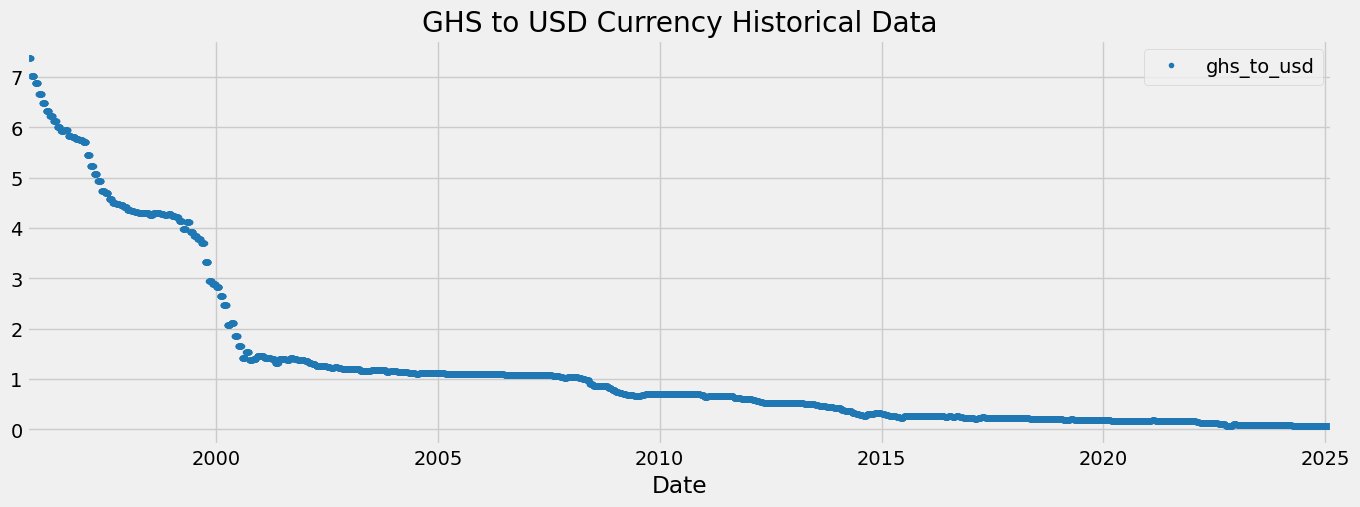

In [86]:
ghs_df_daily.plot(style='.',
                  figsize=(15, 5),
                  color=color_pal[0],
                  title='GHS to USD Currency Historical Data')
plt.savefig("usd_ghs.png")
plt.show()

In [87]:
oil_df.columns

Index(['oil_price'], dtype='object')

In [88]:
oil_df = pd.read_csv(path+"Cushing_OK_WTI_Spot_Price_FOB.csv", skiprows=4)
oil_df = oil_df.iloc[::-1].reset_index(drop=True)
oil_df["Date"] = pd.to_datetime(oil_df["Day"], format="%m/%d/%Y")
oil_df = oil_df.set_index("Date")
oil_df["oil_price"] = oil_df["Cushing OK WTI Spot Price FOB  Dollars per Barrel"]
oil_df = oil_df.drop(["Day", "Cushing OK WTI Spot Price FOB  Dollars per Barrel"], axis=1)
oil_df = oil_df.loc["1994-10-03" : "2025-02-27"]
oil_df

,oil_price
Date,
1994-10-03,18.16
1994-10-04,17.97
1994-10-05,18.01
1994-10-06,18.24
1994-10-07,18.27
...,...
2025-02-21,70.72
2025-02-24,71.06
2025-02-25,69.15


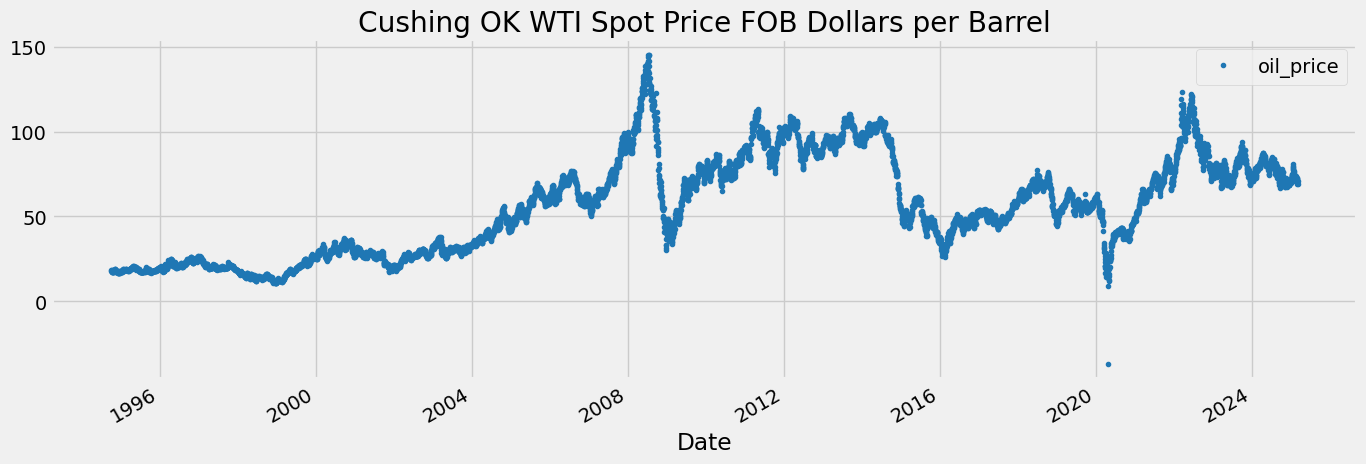

In [89]:
oil_df.plot(style='.',
            figsize=(15, 5),
            color=color_pal[0],
            title='Cushing OK WTI Spot Price FOB Dollars per Barrel')
plt.savefig("oil prices.png")
plt.show()

In [90]:
# 1. Load data
sp_df = pd.read_csv(path+"SP 500 Historical Data.csv")

# 2. Reverse dataframe
sp_df = sp_df.iloc[::-1].reset_index(drop=True)

# 3. Parse dates
sp_df["Date"] = pd.to_datetime(sp_df["Date"], format="%Y-%m-%d")

# 4. Set index
sp_df = sp_df.set_index("Date")

# 5. Safely convert Price column (works whether cleaned or not)
if "Price" in sp_df.columns:
    if sp_df["Price"].dtype == object:  # Only if string type
        sp_df["Price"] = sp_df["Price"].str.replace(",", "").astype(float)
    else:
        sp_df["Price"] = sp_df["Price"].astype(float)  # Ensure float type

# 6. Remove last row if needed (optional)
sp_df = sp_df[:-1] if len(sp_df) > 1 else sp_df

print("Successfully processed data:")
print(sp_df.head())
print("\nColumn dtypes:")
print(sp_df.dtypes)

Successfully processed data:
            Price    Open    High     Low  Vol. Change %
Date                                                    
1994-10-03  461.7  462.70  463.30  460.30   NaN   -0.22%
1994-10-04  454.6  461.80  462.50  454.00   NaN   -1.54%
1994-10-05  453.5  454.60  454.60  449.30   NaN   -0.24%
1994-10-06  452.4  453.50  454.50  452.10   NaN   -0.24%
1994-10-07  455.1  452.40  455.70  452.10   NaN    0.60%

Column dtypes:
Price       float64
Open         object
High         object
Low          object
Vol.        float64
Change %     object
dtype: object


In [91]:
sp_df = pd.read_csv(path+"SP 500 Historical Data.csv")
sp_df = sp_df.iloc[::-1].reset_index(drop=True)
sp_df["Date"] = pd.to_datetime(sp_df["Date"], format="%Y-%m-%d")
sp_df = sp_df.set_index("Date")
sp_df = sp_df.drop(["Vol."], axis=1)
sp_df["Price"] = sp_df["Price"].str.replace(",", "").astype("float")
sp_df = sp_df[:-1]  # repeats in sp_df2
sp_df

,Price,Open,High,Low,Change %
Date,,,,,
1994-10-03,461.7,462.70,463.30,460.30,-0.22%
1994-10-04,454.6,461.80,462.50,454.00,-1.54%
1994-10-05,453.5,454.60,454.60,449.30,-0.24%
1994-10-06,452.4,453.50,454.50,452.10,-0.24%
1994-10-07,455.1,452.40,455.70,452.10,0.60%
...,...,...,...,...,...
2014-08-04,1939.0,"1,926.60","1,942.90","1,921.20",0.72%
2014-08-05,1920.2,"1,936.30","1,936.30","1,913.80",-0.97%
2014-08-06,1920.2,"1,917.30","1,927.90","1,911.50",0.00%


In [92]:
sp_df2 = pd.read_csv(path+"SP 500 Historical Data 2.csv")
sp_df2 = sp_df2.iloc[::-1].reset_index(drop=True)
sp_df2["Date"] = pd.to_datetime(sp_df2["Date"], format="%Y-%m-%d")
sp_df2 = sp_df2.set_index("Date")
sp_df2 = sp_df2.drop(["Vol."], axis=1)
sp_df2["Price"] = sp_df2["Price"].str.replace(",", "").astype("float")
sp_df2 = sp_df2[:-1]
sp_df2

,Price,Open,High,Low,Change %
Date,,,,,
2014-08-11,1936.90,"1,933.40","1,944.90","1,933.40",0.27%
2014-08-12,1933.80,"1,935.70","1,939.70","1,928.30",-0.16%
2014-08-13,1946.70,"1,935.60","1,948.40","1,935.60",0.67%
2014-08-14,1955.20,"1,947.40","1,955.20","1,947.40",0.44%
2014-08-15,1955.10,"1,958.90","1,964.00","1,941.50",-0.01%
...,...,...,...,...,...
2025-02-21,6013.13,"6,114.10","6,114.82","6,008.56",-1.71%
2025-02-24,5983.25,"6,026.69","6,043.65","5,977.83",-0.50%
2025-02-25,5955.25,"5,982.73","5,992.65","5,908.49",-0.47%


In [93]:
sp_df3 = pd.concat([sp_df, sp_df2], axis=0)
sp_df3["sp500_price"] = sp_df3["Price"]
sp_df3.drop(["Price", "Open", "High", "Low", "Change %"], axis=1, inplace=True)
sp_df3

,sp500_price
Date,
1994-10-03,461.70
1994-10-04,454.60
1994-10-05,453.50
1994-10-06,452.40
1994-10-07,455.10
...,...
2025-02-21,6013.13
2025-02-24,5983.25
2025-02-25,5955.25


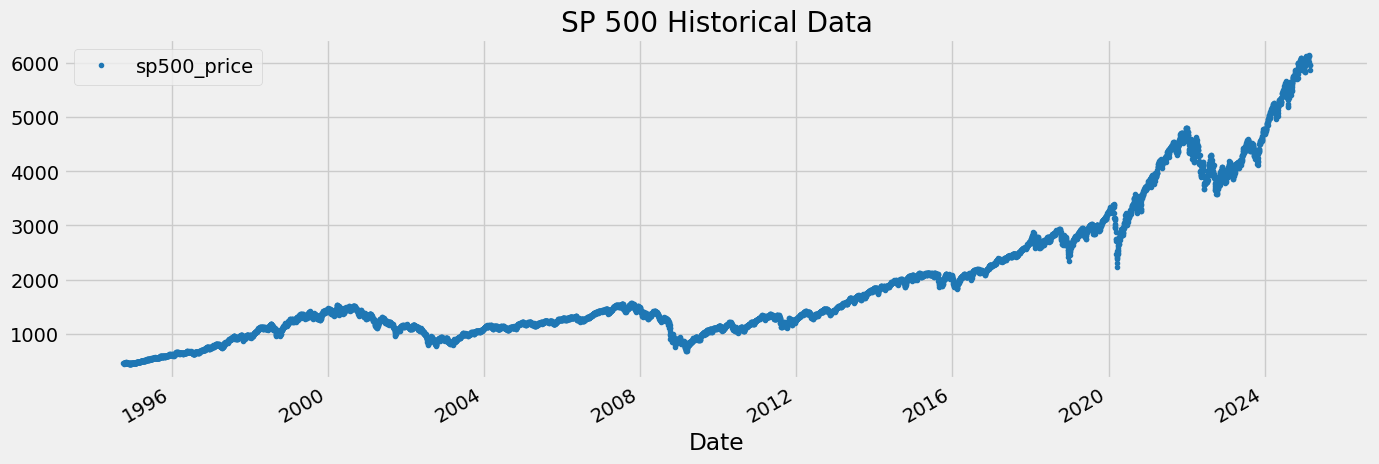

In [94]:
sp_df3.plot(style='.',
            figsize=(15, 5),
            color=color_pal[0],
            title='SP 500 Historical Data')
plt.savefig("sp500.png")
plt.show()

In [95]:
final_df = pd.merge(pd.merge(pd.merge(icco_df, ghs_df_daily, on="Date"), oil_df, on="Date"), sp_df3, on="Date")
final_df

,icco_daily_price,ghs_to_usd,oil_price,sp500_price
Date,,,,
1995-10-03,1372.80,7.380074,17.56,582.30
1995-10-04,1381.55,7.380074,17.32,581.50
1995-10-05,1375.45,7.380074,16.86,582.60
1995-10-06,1373.33,7.380074,17.03,582.50
1995-10-09,1375.14,7.380074,17.36,578.40
...,...,...,...,...
2025-02-21,9106.42,0.064725,70.72,6013.13
2025-02-24,8408.72,0.064725,71.06,5983.25
2025-02-25,8668.57,0.064725,69.15,5955.25


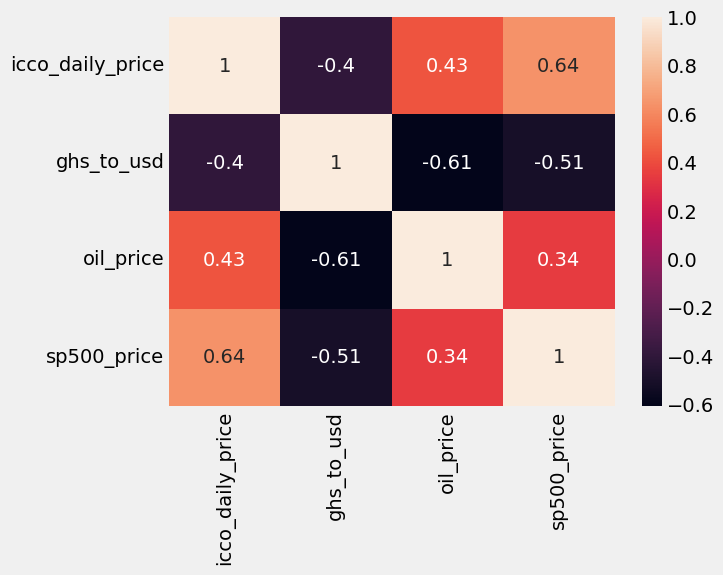

In [96]:
sns.heatmap(final_df.corr(numeric_only=True), annot=True);

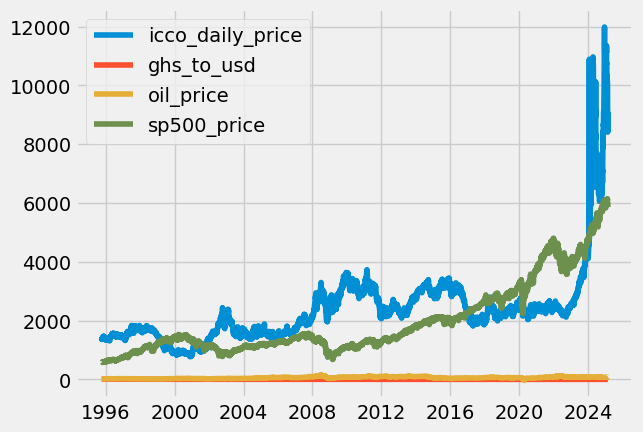

In [97]:
plt.plot(final_df["icco_daily_price"], label="icco_daily_price")
plt.plot(final_df["ghs_to_usd"], label="ghs_to_usd")
plt.plot(final_df["oil_price"], label="oil_price")
plt.plot(final_df["sp500_price"], label="sp500_price")
plt.legend()
plt.show()

In [98]:
len1 = int(0.8*len(final_df))
len2 = int(0.9*len(final_df))
train_df = final_df[:len1]
valid_df = final_df[len1:len2]
test_df = final_df[len2:]

print("train_df:", len("train_df")*"-", train_df, sep='\n')
print("\n\nvalid_df:", len("valid_df")*"-", valid_df, sep='\n')
print("\n\ntest_df:", len("test_df")*"-", test_df, sep='\n')

train_df:
--------
            icco_daily_price  ghs_to_usd  oil_price  sp500_price
Date                                                            
1995-10-03           1372.80    7.380074      17.56        582.3
1995-10-04           1381.55    7.380074      17.32        581.5
1995-10-05           1375.45    7.380074      16.86        582.6
1995-10-06           1373.33    7.380074      17.03        582.5
1995-10-09           1375.14    7.380074      17.36        578.4
...                      ...         ...        ...          ...
2019-04-03           2340.33    0.194522      62.46       2873.4
2019-04-04           2363.93    0.194522      62.12       2879.4
2019-04-05           2362.78    0.194522      63.10       2892.7
2019-04-08           2364.16    0.194522      64.37       2895.8
2019-04-09           2373.43    0.194522      64.05       2878.2

[5890 rows x 4 columns]


valid_df:
--------
            icco_daily_price  ghs_to_usd  oil_price  sp500_price
Date                     

In [99]:
train_df.to_csv("../working/train_df.csv")
valid_df.to_csv("../working/valid_df.csv")
test_df.to_csv("../working/test_df.csv")

OSError: Cannot save file into a non-existent directory: '..\working'

In [100]:
# 1. Verify the data directory exists or create it
data_dir = '../data/'
os.makedirs(data_dir, exist_ok=True)  # Creates directory if it doesn't exist

# 2. Save your files with clear paths
train_df.to_csv(os.path.join(data_dir, 'train_df.csv'))
valid_df.to_csv(os.path.join(data_dir, 'valid_df.csv'))
test_df.to_csv(os.path.join(data_dir, 'test_df.csv'))

print(f"Files saved successfully to {os.path.abspath(data_dir)}")

Files saved successfully to c:\Users\domen\Desktop\UofT 24_25\STA457\Final Project\ts_for_cocoa\data


In [ ]:
# os.listdir("../working/")

In [ ]:
# icco_df.to_csv("../working/new ICCO daily price.csv")
# xof_df.to_csv("../working/new XOF.csv")
# ghana_df.to_csv("../working/new ghana.csv")
# ghs_df.to_csv("../working/new GHS.csv")
# oil_df.to_csv("../working/new_oil.csv")
# sp_df3.to_csv("../working/new_sp500.csv")